In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist,squareform
import scipy
def twoDRBF(u,v):
    uvn = np.linalg.norm(u-v)
    return uvn**2 * np.log(uvn+1e-12)


In [2]:
X = [[-1,1],[0,1],[1,1],[-1,-1],[0,-1],[1,-1]]
y = [[-1,0,1,-1,0,1]]
X = np.array(X)
y = np.array(y).T

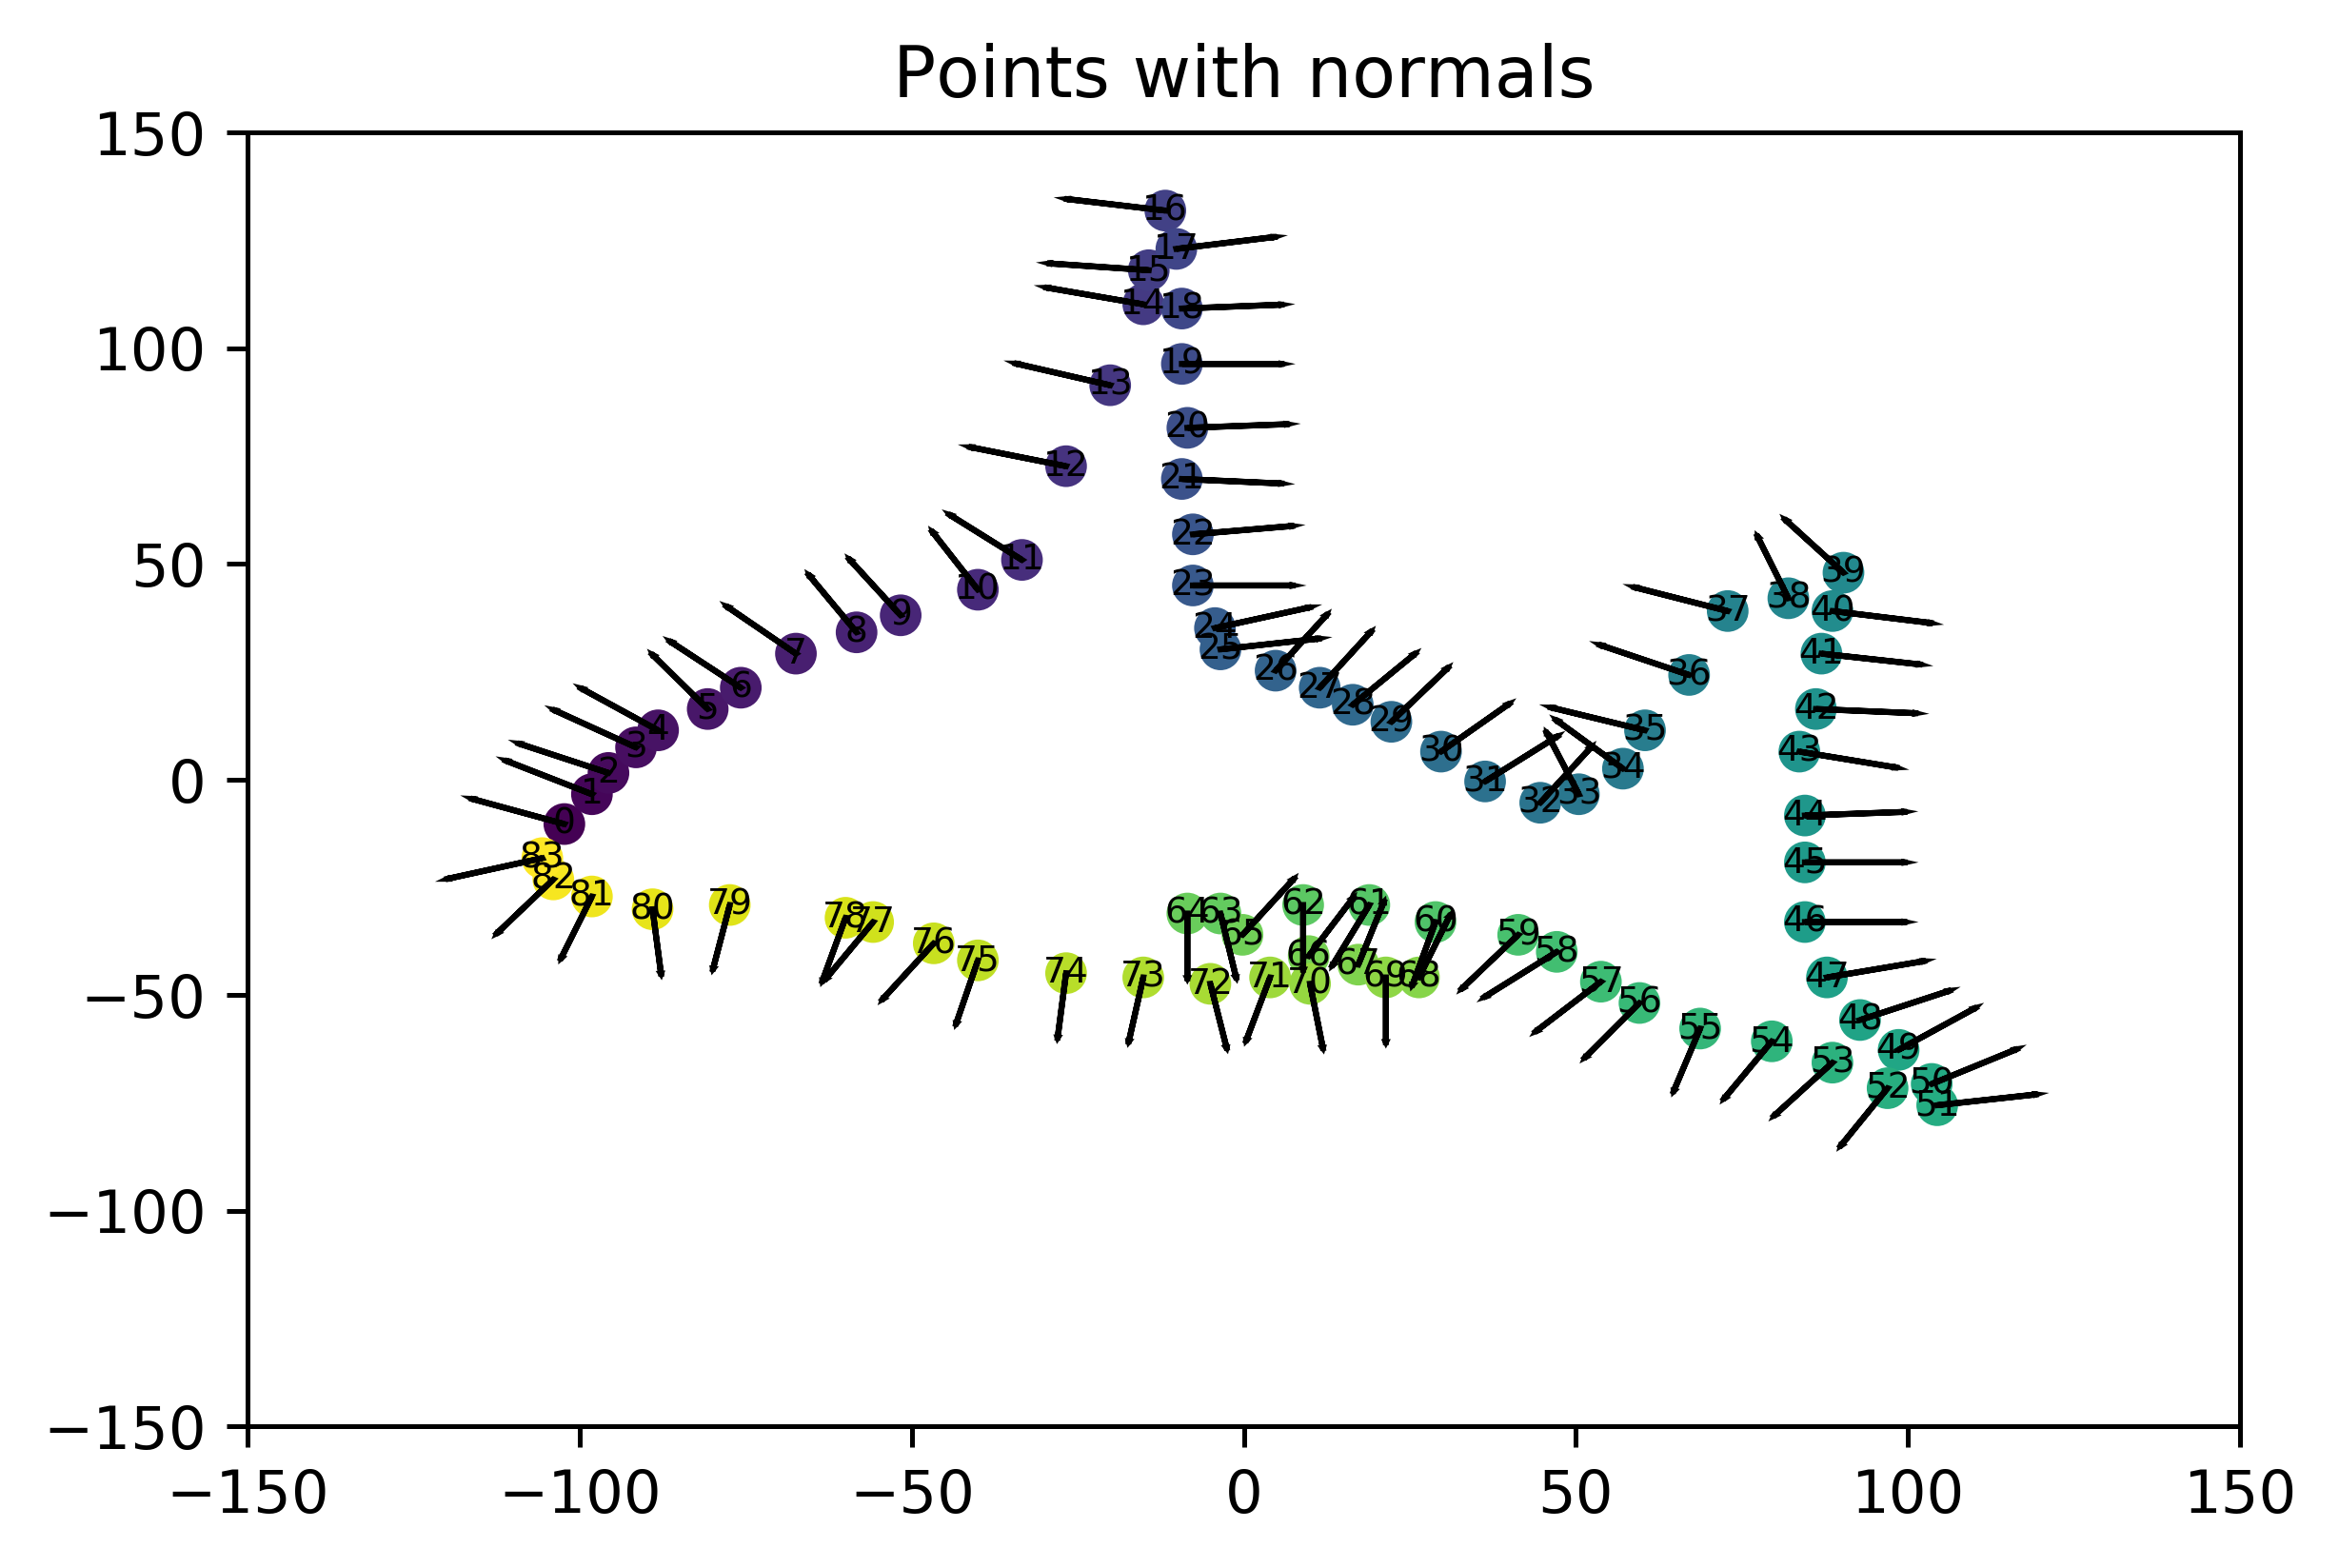

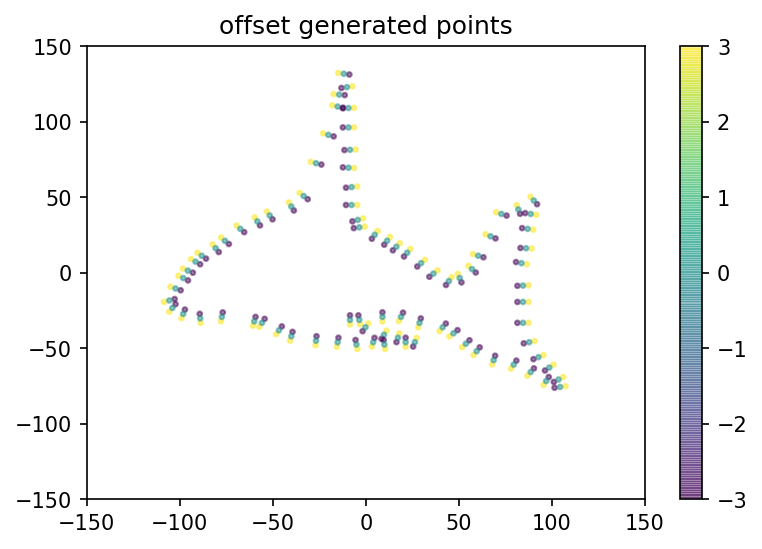

In [3]:
#def compute_normals(X):
if True:
    Xs = []
    Ys = []
    X = np.loadtxt('fish_target.txt')
    #X = np.vstack([X,[[-0.3,1.0],[-0.22,1.35]]])
    X[:,1] *= 5/8
    X *= 100
    #plt.scatter(X[:,0],X[:,1],c='k')
    #dist = squareform(pdist(X,'sqeuclidean'))
    normals = []
    c, s = np.cos(np.pi/2), np.sin(np.pi/2)
    A = np.array([[c, s], [-s, c]])
    for i in range(len(X)):
        p1 = X[i]
        p2 = X[i-1]
        nm = p2 - p1
        nm /= np.linalg.norm(nm)
        nm =  nm @ A.T
        normals.append(nm)
        Xs.append(p1 + 3*nm)
        Ys.append(3)
        Xs.append(p1 - 3*nm)
        Ys.append(-3)
        Xs.append(p1)
        Ys.append(0)

    normals = np.array(normals)
    plt.figure(dpi=450)
    plt.scatter(X[:,0],X[:,1],c=np.arange(len(X)))
    #normals = np.array(pcd.normals)[:,:2]
    for p,n in zip(X,normals):
        #r = p +n
        #print(p,n)
        plt.arrow(p[0],p[1],15*n[0],15*n[1])
    for i in range(len(X)):
        plt.text(X[i,0],X[i,1],'{}'.format(i),fontsize=6,ha='center',va='center')
    plt.xlim(-150,150)
    plt.ylim(-150,150)
    plt.title('Points with normals')
    plt.figure(dpi=150)
    xO = X.copy()
    X = np.array(Xs)
    y = np.array(Ys)[:,np.newaxis]
    plt.scatter(X[:,0],X[:,1],c=y[:,0],s=5,alpha=0.5)
    plt.colorbar()
    plt.xlim(-150,150)
    plt.ylim(-150,150)
    plt.title('offset generated points')

In [4]:
X.shape,y.shape

((252, 2), (252, 1))

In [5]:
K = squareform(pdist(X,'sqeuclidean'))
K = np.exp(-K/100)
Kinv = scipy.linalg.solve(K + 1*np.identity(K.shape[0]),np.identity(len(K)),sym_pos=True)

In [6]:
nx, ny = (100,100)
xC = np.linspace(-150,150,nx)
yC = np.linspace(-150, 150, ny)
xv, yv = np.meshgrid(xC, yC)


In [7]:
points = np.stack([xv.ravel(),yv.ravel()]).T

In [8]:
Kn = cdist(points,X,'sqeuclidean')
Kn = np.exp(-Kn/100)

Knn = squareform(pdist(points,'sqeuclidean'))
Knn = np.exp(-Knn/100)


Text(0.5, 1.0, 'Point-Point Distance')

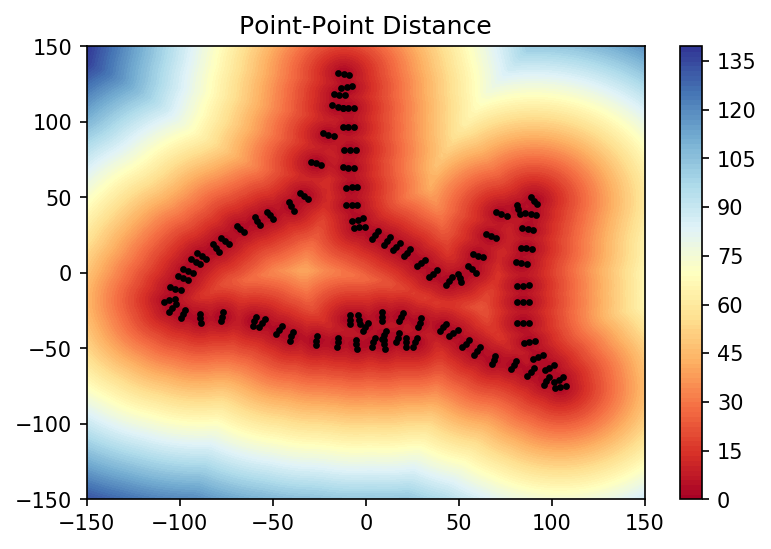

In [9]:
odist = cdist(xO,points,'sqeuclidean')

plt.figure(dpi=150)
plt.contourf(xC,yC,np.min(np.sqrt(odist),0).reshape(xv.shape),cmap='RdYlBu',levels=125)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('Point-Point Distance')

Text(0.5, 1.0, 'Point-Plane Distance')

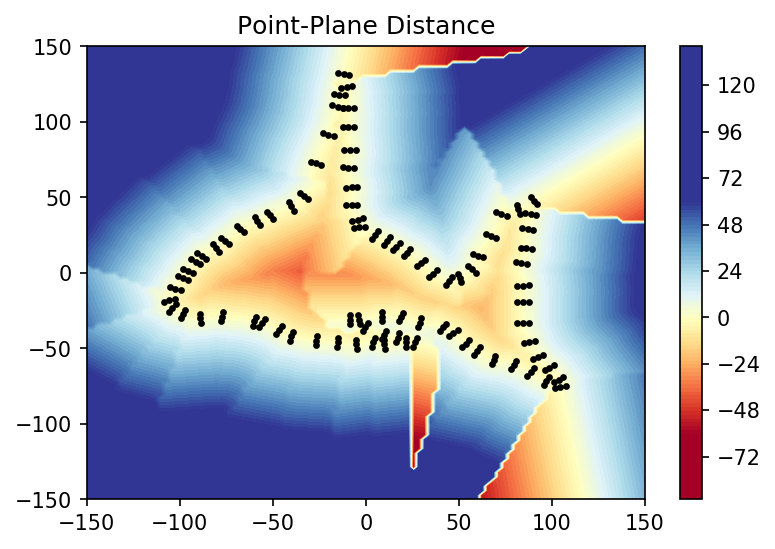

In [10]:
nearest_idx = np.argmin(odist,0)
nearest_pts = xO[nearest_idx]
nearest_nrm = normals[nearest_idx]
plane_dist = ((points-nearest_pts) * nearest_nrm).sum(1)
plt.figure(dpi=150)
plt.contourf(xC,yC,plane_dist.reshape(xv.shape),cmap='RdYlBu',levels=125,vmin=-60,vmax=60)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('Point-Plane Distance')

In [11]:
Kn.shape,Kinv.shape, y.shape

((10000, 252), (252, 252), (252, 1))

In [12]:
mean_func = Kn @ Kinv @ y


Text(0.5, 1.0, 'GP Mean')

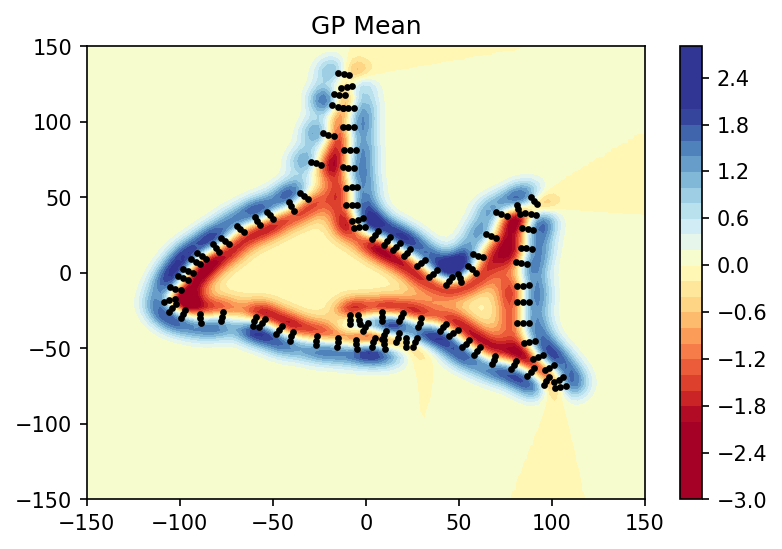

In [13]:
plt.figure(dpi=150)
plt.contourf(xC,yC,mean_func.reshape(xv.shape),cmap='RdYlBu',levels=35,vmin=-2,vmax=2)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('GP Mean')

In [14]:
var_func = Knn + 1*np.identity(Knn.shape[0]) - Kn @ Kinv @ Kn.T

Text(0.5, 1.0, 'GP variance')

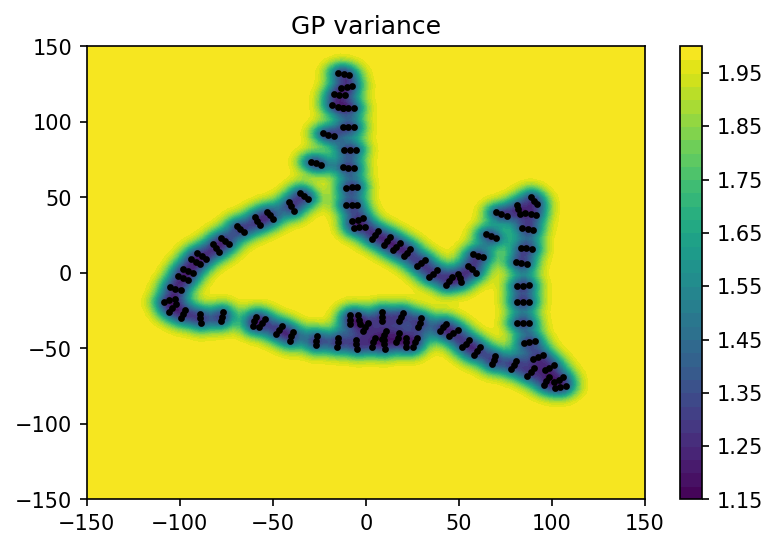

In [15]:
plt.figure(dpi=150)
plt.contourf(xC,yC,np.diag(var_func).reshape(xv.shape),levels=35)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('GP variance')

In [16]:
var_func.shape

(10000, 10000)

In [17]:
#pcd = o3d.geometry.PointCloud()
#pcd.points = o3d.utility.Vector3dVector(np.hstack([X,np.zeros_like(X)[:,0:1]]))

In [18]:
#from open3d.open3d.geometry import voxel_down_sample,estimate_normals
#estimate_normals(pcd,search_param=o3d.geometry.KDTreeSearchParamKNN(5))

In [19]:
#o3d.visualization.draw_geometries([pcd])

In [20]:
pos_const = xO + normals*3
vs_X = np.vstack([pos_const,xO])

In [21]:
# variational surface time
dm = pdist(vs_X, twoDRBF)
#dm = pdist(vs_X, 'minkowski',p=3)
#dm = abs(dm)
dM = squareform(dm)
mM = np.hstack([dM,np.ones(len(dM))[:,np.newaxis],vs_X])
dS = mM.shape[1]-dM.shape[1]

vs_A = np.vstack([mM,np.hstack([np.ones(len(dM)),np.zeros(dS)]),np.pad(vs_X.T,((0,0),(0,dS)),'constant') ])
vs_b = np.zeros(len(vs_A))
vs_b[:len(pos_const)] =3

vs_est = np.linalg.solve(vs_A,vs_b)

In [22]:
#vs_est

In [23]:
pred_vs_d = cdist(points,vs_X, twoDRBF)
#pred_vs_d = cdist(points,vs_X, 'minkowski',p=3)
pred_vs_d = abs(pred_vs_d)

In [24]:
pad_vs_d = np.hstack([pred_vs_d,np.ones(len(pred_vs_d))[:,np.newaxis],points])

Text(0.5, 1.0, 'variational (clipped at +/- 15)')

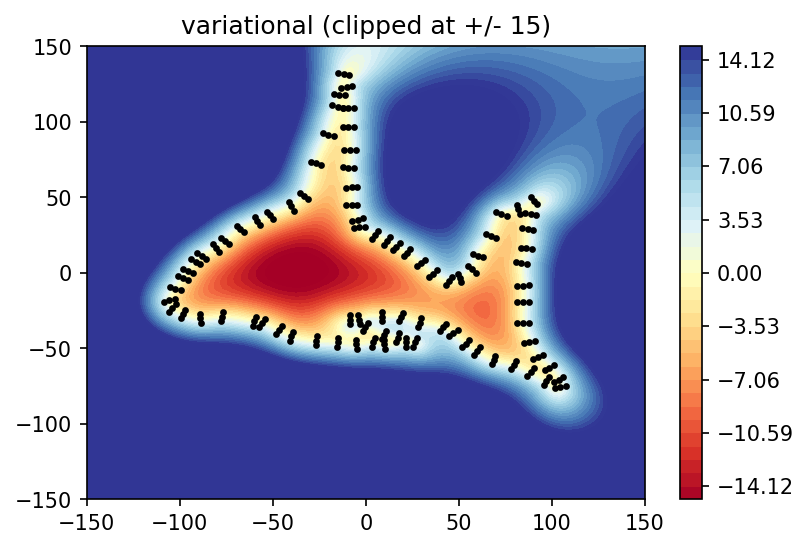

In [25]:
import matplotlib.cm as cm
vs_res = (pad_vs_d @ vs_est)
plt.figure(dpi=150)
plt.contourf(xC,yC,vs_res.reshape(xv.shape),cmap='RdYlBu',levels=125,vmin=-15,vmax=15)
m = plt.cm.ScalarMappable(cmap=cm.RdYlBu)
m.set_array(vs_res.reshape(xv.shape))
m.set_clim(-15,15)
plt.colorbar(m, boundaries=np.linspace(-15, 15, 35))
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('variational (clipped at +/- 15)')

Text(0.5, 1.0, 'Point-Point Distance')

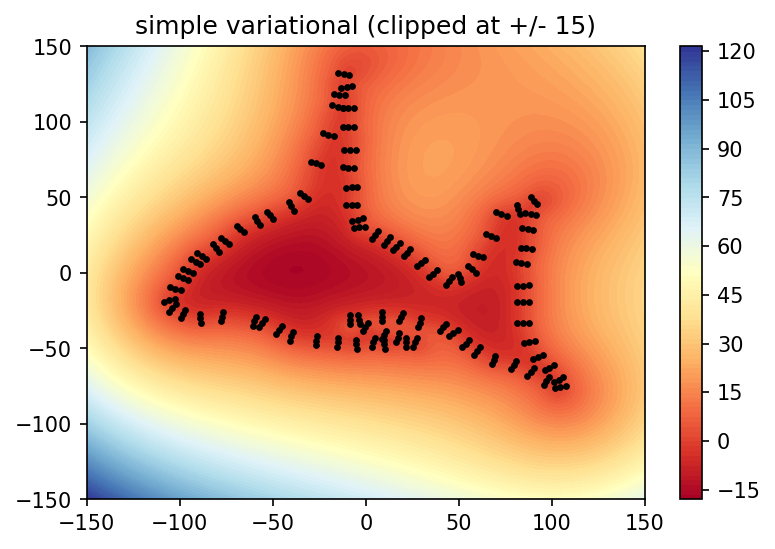

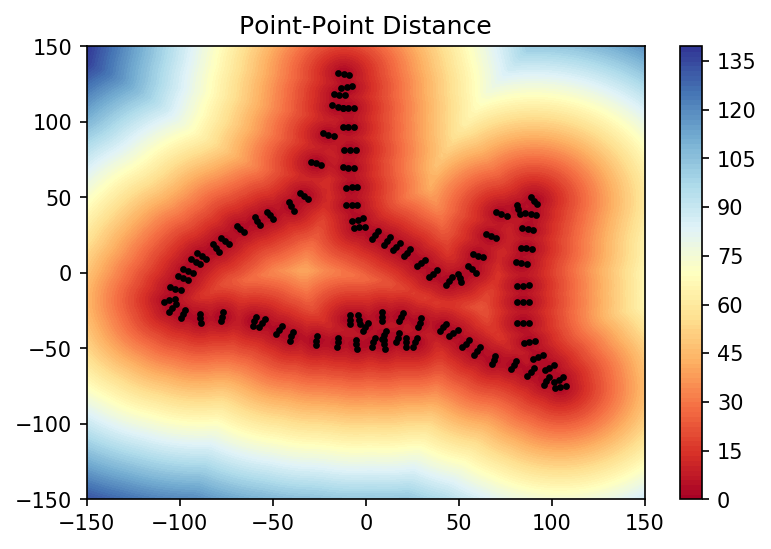

In [26]:
simple_b = vs_b[:len(dM)]
simple_est = np.linalg.solve(dM,simple_b)

#simple_res = pred_vs_d @ simple_est
simple_res = pred_vs_d @ simple_est #np.linalg.pinv(dM) @ simple_b
plt.figure(dpi=150)
plt.contourf(xC,yC,simple_res.reshape(xv.shape),cmap='RdYlBu',levels=125)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('simple variational (clipped at +/- 15)')
plt.figure(dpi=150)
plt.contourf(xC,yC,np.min(np.sqrt(odist),0).reshape(xv.shape),cmap='RdYlBu',levels=125)
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c='k',s=5)
plt.title('Point-Point Distance')

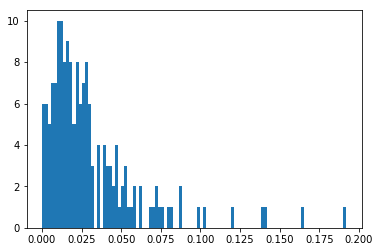

In [27]:
_ = plt.hist((np.sqrt(simple_est**2)),100)

In [28]:
import statsmodels.api as sm

In [29]:
clf = sm.OLS(simple_b,dM)
mf = clf.fit_regularized(alpha=6e2,refit=False,L1_wt=1)
#mf

In [30]:
#cv = np.argsort((np.sqrt(simple_est**2)))
print((mf.params!=0).sum()/mf.params.shape[0])
best_idx = np.where(mf.params!=0)[0]#cv[-50:]

0.26785714285714285


In [31]:
d2 = dM[best_idx]
d3 = d2[:,best_idx]

Text(0.5, 1.0, 'Point-Plane Distance')

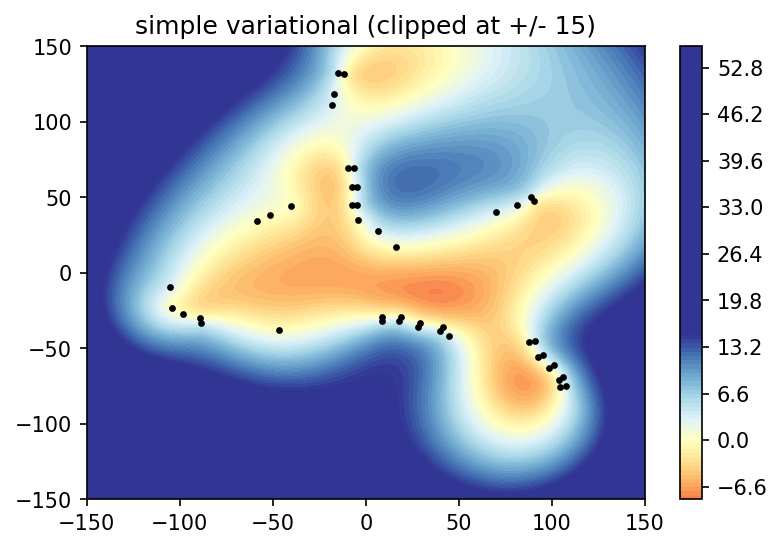

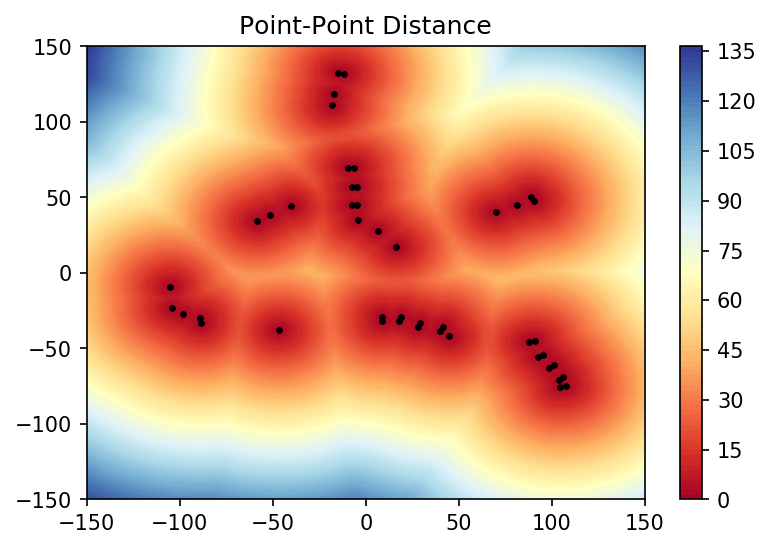

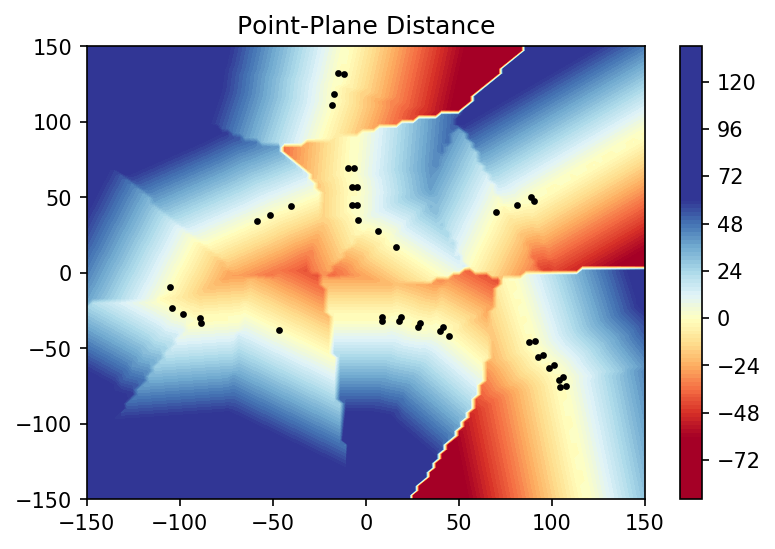

In [32]:
simple_est2 = np.linalg.solve(d3,simple_b[best_idx])
simple_res2 = pred_vs_d[:,best_idx] @ simple_est2
plt.figure(dpi=150)
plt.contourf(xC,yC,simple_res2.reshape(xv.shape),cmap='RdYlBu',levels=125,vmin=-15,vmax=15)
plt.colorbar()
plt.scatter(vs_X[best_idx,0],vs_X[best_idx,1],c='k',s=5)
plt.title('simple variational (clipped at +/- 15)')

odist_part = cdist(vs_X[best_idx],points,'sqeuclidean')
plt.figure(dpi=150)
plt.contourf(xC,yC,np.min(np.sqrt(odist_part),0).reshape(xv.shape),cmap='RdYlBu',levels=125)
plt.colorbar()
plt.scatter(vs_X[best_idx,0],vs_X[best_idx,1],c='k',s=5)
plt.title('Point-Point Distance')

nearest_idx = np.argmin(odist_part,0)
idx_hack = np.arange(len(dM))[best_idx][nearest_idx]
nearest_pts = vs_X[idx_hack]
nearest_nrm = np.vstack([normals,normals])[idx_hack]
plane_dist = ((points-nearest_pts) * nearest_nrm).sum(1)

plt.figure(dpi=150)
plt.contourf(xC,yC,plane_dist.reshape(xv.shape),cmap='RdYlBu',levels=125,vmin=-60,vmax=60)
plt.colorbar()
plt.scatter(vs_X[best_idx,0],vs_X[best_idx,1],c='k',s=5)
plt.title('Point-Plane Distance')

In [33]:
#nearest_nrm = normals[np.arange(len(dM))[best_idx][nearest_idx]]
#normals.shape,len(dM),max(best_idx)
n#p.vstack([normals,normals]).shape

array([-0.94785891, -0.31869026])

In [34]:
EPS = 1e3
EPS2 = 0#1e-9
NV = 50
initial = np.hstack([50*np.random.randn(2*NV),10*np.random.randn(NV)])
initial = np.hstack([vs_X[best_idx],simple_b[best_idx,np.newaxis]])

def test_fit(x):
    xR = x.reshape((-1,3))

    dmL = pdist(xR[:,:-1], 'minkowski',p=3)
    dmL = abs(dmL)
    #dmL = np.exp(-dmL/EPS)
    dML = squareform(dmL)
    simple_estL = np.linalg.solve(dML + np.identity(len(dML))*EPS2,xR[:,-1])
    tL = cdist(vs_X,xR[:,:-1], 'minkowski',p=3)
    tL = abs(tL)
    #tL = np.exp(-tL/EPS)

    lr = tL @ simple_estL
    err = np.linalg.norm(lr-y,axis=1).mean()
    return err

#initial = np.random.randn(3*20)*100
#initial = np.hstack([vs_X,simple_b[:,np.newaxis]])

test_fit( np.random.randn(3*20)),test_fit( initial),initial.shape


(523.711151812678, 38.44571909931447, (45, 3))

In [35]:
import scipy.optimize

In [36]:
#optR = scipy.optimize.minimize(test_fit,initial,options={'disp':True})
#print(optR)

In [37]:
#optR = scipy.optimize.differential_evolution(test_fit,[(-150,150),(-150,150),(-5,5)]*15,maxiter=50,disp=True,polish=False)#,np.random.rand(3*20),options={'disp':True})

Text(0.5, 1.0, 'simple variational (clipped at +/- 15)')

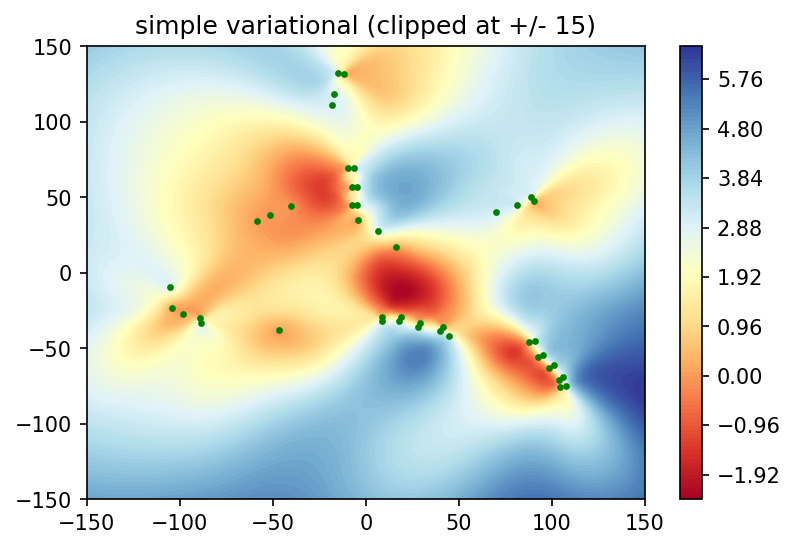

In [38]:
xR = initial.reshape((-1,3))

dmL = pdist(xR[:,:-1], 'minkowski',p=3)
dmL = abs(dmL)
#dmL = np.exp(-dmL/EPS)
dML = squareform(dmL)
simple_estL = np.linalg.solve(dML+ np.identity(len(dML))*EPS2,xR[:,-1])
tL = cdist(points,xR[:,:-1],'minkowski',p=3)
tL = abs(tL)
#tL = np.exp(-tL/EPS)
plt.figure(dpi=150)
plt.contourf(xC,yC,(tL @ simple_estL).reshape(xv.shape),cmap='RdYlBu',levels=125)
plt.colorbar()
#plt.scatter(X[best_idx,0],X[best_idx,1],c='k',s=5)
plt.scatter(xR[:,0],xR[:,1],s=5,c='g')
plt.title('simple variational (clipped at +/- 15)')